In [1]:
# Install required packages
!pip install -q transformers datasets evaluate accelerate peft trl bitsandbytes matplotlib torchsummary pandas scikit-learn kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import necessary libraries
import os
import gc
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, PeftModelForSequenceClassification
from tqdm.auto import tqdm
from torch.utils.data import DataLoader


In [3]:
# Set seed for reproducibility
def set_seed(seed=42):
    """Set seed for all random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:
print("Loading AG News dataset...")
# Load train data from Hugging Face datasets
dataset = load_dataset('ag_news', split='train')

# Load test data
try:
    # Try to load the test data from a local file
    with open("test_unlabelled.pkl", "rb") as f:
        test_df = pickle.load(f)
    print("Test data loaded from local file.")
except:
    # If local file not found, request manual upload
    from google.colab import files
    print("Please upload test_unlabelled.pkl file.")
    uploaded = files.upload()
    with open("test_unlabelled.pkl", "rb") as f:
        test_df = pickle.load(f)
    print("Test data loaded from uploaded file.")

# Print dataset statistics
print(f"Train set size: {len(dataset)} | Test set size: {len(test_df)}")

Loading AG News dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Please upload test_unlabelled.pkl file.


Saving test_unlabelled.pkl to test_unlabelled.pkl
Test data loaded from uploaded file.
Train set size: 120000 | Test set size: 8000


In [5]:
# Display dataset information
label_names = dataset.features['label'].names
print(f"Classes: {label_names}")

# Display class distribution in training set
label_counts = pd.Series([label_names[x['label']] for x in dataset]).value_counts()
print("\nClass distribution in training set:")
print(label_counts)

Classes: ['World', 'Sports', 'Business', 'Sci/Tech']

Class distribution in training set:
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64


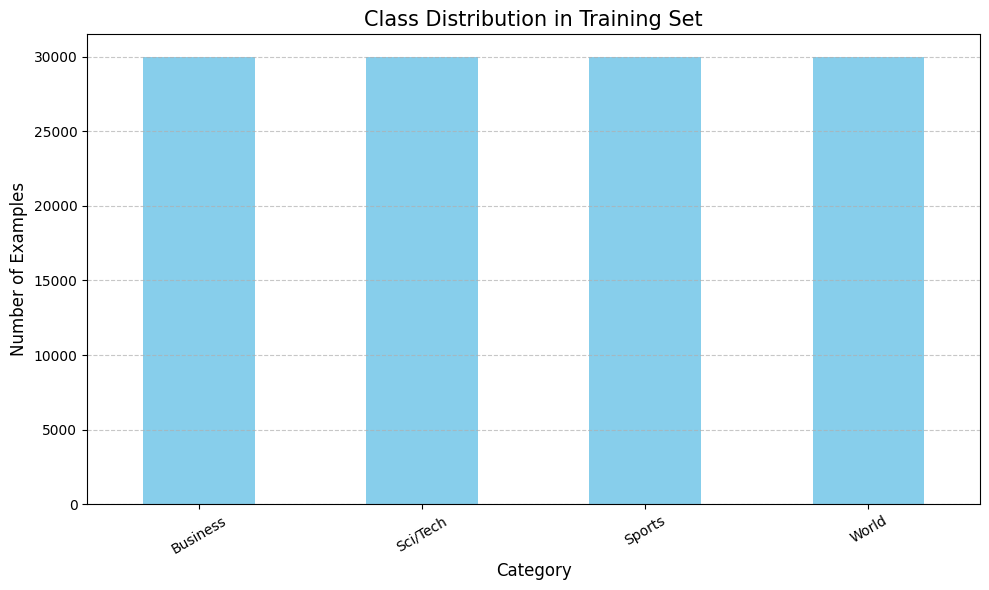

In [6]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Class Distribution in Training Set", fontsize=15)
plt.ylabel("Number of Examples", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('class_distribution.png')
plt.show()

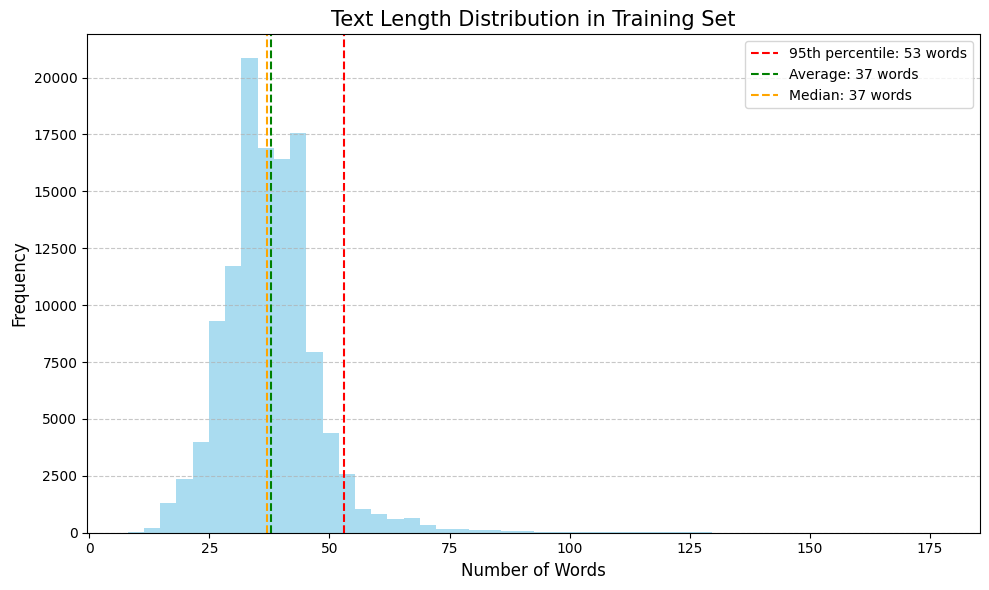

In [7]:
# Analyze text length distribution
lengths = [len(x['text'].split()) for x in dataset]
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, color='skyblue', alpha=0.7)
plt.title("Text Length Distribution in Training Set", fontsize=15)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.axvline(np.percentile(lengths, 95), color='r', linestyle='--', label=f'95th percentile: {int(np.percentile(lengths, 95))} words')
plt.axvline(np.mean(lengths), color='g', linestyle='--', label=f'Average: {int(np.mean(lengths))} words')
plt.axvline(np.median(lengths), color='orange', linestyle='--', label=f'Median: {int(np.median(lengths))} words')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('text_length_distribution.png')
plt.show()


In [8]:
# Print descriptive statistics of text lengths
print("\nText length statistics (word count):")
print(f"Min: {min(lengths)}")
print(f"Max: {max(lengths)}")
print(f"Mean: {np.mean(lengths):.2f}")
print(f"Median: {np.median(lengths)}")
print(f"95th percentile: {np.percentile(lengths, 95)}")



Text length statistics (word count):
Min: 8
Max: 177
Mean: 37.85
Median: 37.0
95th percentile: 53.0


In [9]:
print("\nLoading RoBERTa tokenizer...")
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Set maximum sequence length based on data analysis
max_length = 128  # This covers most articles based on text length analysis

# Function to tokenize input text
def tokenize_fn(examples):
    """Tokenize text data with padding and truncation."""
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=max_length
    )

print("Tokenizing training data...")
# Process the training dataset
tokenized_dataset = dataset.map(
    tokenize_fn,
    batched=True,
    remove_columns=["text"],
    desc="Tokenizing training data"
)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

print("Tokenizing test data...")
# Process the test dataset
# Ensure the test dataset has the right format
if not isinstance(test_df, Dataset):
    # If it's a DataFrame, we need to convert
    if hasattr(test_df, 'to_pandas'):
        print("Converting test_df to pandas DataFrame")
        test_df = test_df.to_pandas()
    # Now create a Dataset
    test_dataset = Dataset.from_dict({"text": test_df["text"].tolist()})
else:
    # Already a Dataset
    test_dataset = test_df

tokenized_test = test_dataset.map(
    tokenize_fn,
    batched=True,
    remove_columns=["text"],
    desc="Tokenizing test data"
)

# Prepare label mapping for the model
num_labels = len(label_names)
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

# Setup data collator for batching
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print(f"Tokenization complete - Training examples: {len(tokenized_dataset)}, Test examples: {len(tokenized_test)}")

# Create a validation set from the training data
print("Creating train/validation split...")
split = tokenized_dataset.train_test_split(test_size=0.1, seed=42, stratify_by_column="labels")
train_dataset = split["train"]
val_dataset = split["test"]
print(f"Train: {len(train_dataset)} examples | Validation: {len(val_dataset)} examples")


Loading RoBERTa tokenizer...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Tokenizing training data...


Tokenizing training data:   0%|          | 0/120000 [00:00<?, ? examples/s]

Tokenizing test data...


Tokenizing test data:   0%|          | 0/8000 [00:00<?, ? examples/s]

Tokenization complete - Training examples: 120000, Test examples: 8000
Creating train/validation split...
Train: 108000 examples | Validation: 12000 examples


In [10]:
print("\nInitializing RoBERTa model...")

# Load base RoBERTa model
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Count base parameters
total_base_params = sum(p.numel() for p in model.parameters())
print(f"Base model total parameters: {total_base_params:,}")

# === First Attempt: Full LoRA Config ===
print("\nConfiguring initial LoRA adapter...")
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "key", "value"],
    task_type="SEQ_CLS"
)

try:
    peft_model = get_peft_model(model, lora_config)

    # ❄️ Freeze classifier layer
    for name, param in peft_model.named_parameters():
        if "classifier" in name:
            param.requires_grad = False

    # Recount parameters
    trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in peft_model.parameters())

    print(f"\n===== MODEL PARAMETER ANALYSIS =====")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")
    print(f"Trainable percentage: {100 * trainable_params / total_params:.2f}%")

    if trainable_params > 1_000_000:
        raise ValueError("❌ Model exceeds 1M trainable parameter limit.")

    print(f"✅ MODEL COMPLIES WITH 1M PARAMETER BUDGET: {trainable_params:,} trainable parameters")

except ValueError as e:
    print(f"\n⚠️ {e}")
    print("Adjusting LoRA config to lower rank...")

    # === Fallback LoRA Config ===
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        target_modules=["query"],  # less aggressive
        task_type="SEQ_CLS"
    )

    peft_model = get_peft_model(model, lora_config)

    # ❄️ Freeze classifier again
    for name, param in peft_model.named_parameters():
        if "classifier" in name:
            param.requires_grad = False

    # Recount parameters
    trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in peft_model.parameters())

    print(f"\n===== FALLBACK MODEL PARAMETER ANALYSIS =====")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")
    print(f"Trainable percentage: {100 * trainable_params / total_params:.2f}%")

    if trainable_params <= 1_000_000:
        print(f"✅ MODEL COMPLIES WITH 1M PARAMETER BUDGET: {trainable_params:,} trainable parameters")
    else:
        raise ValueError(f"❌ Even fallback config exceeds 1M params: {trainable_params:,}")



Initializing RoBERTa model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model total parameters: 124,648,708

Configuring initial LoRA adapter...

===== MODEL PARAMETER ANALYSIS =====
Total parameters: 126,127,112
Trainable parameters: 884,736
Frozen parameters: 125,242,376
Trainable percentage: 0.70%
✅ MODEL COMPLIES WITH 1M PARAMETER BUDGET: 884,736 trainable parameters


In [11]:
print("\nSetting up training configuration...")

# Define training arguments (compatible with transformers==4.51.3)
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",             # ✅ Correct key for older versions
    eval_steps=500,                    # Evaluate every 500 steps
    save_strategy="steps",             # Save strategy
    save_steps=500,                    # Save checkpoint every 500 steps
    save_total_limit=2,                # Keep only the last 2 checkpoints
    logging_dir="./logs",              # Log directory
    logging_steps=100,                 # Log every 100 steps
    per_device_train_batch_size=16,    # Adjust based on GPU memory
    per_device_eval_batch_size=64,     # Higher batch size for evaluation
    num_train_epochs=10,                # Number of training epochs
    learning_rate=2e-4,                # Learning rate for LoRA fine-tuning
    weight_decay=0.01,                 # Regularization
    gradient_accumulation_steps=2,     # Effective batch size = 16*2 = 32
    fp16=True,                         # Use mixed precision training
    warmup_ratio=0.1,                  # Warmup for 10% of training
    load_best_model_at_end=True,       # Restore best checkpoint after training
    metric_for_best_model="accuracy",  # Metric to monitor
    greater_is_better=True,            # Higher accuracy = better
    report_to="none"                   # Disable external logging
)

# Define evaluation metric function
def compute_metrics(eval_pred):
    """Calculate classification metrics from predictions."""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds)
    }

# Initialize the Trainer with early stopping
print("Initializing Trainer with early stopping...")
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)



Setting up training configuration...
Initializing Trainer with early stopping...


<ipython-input-11-4d7a64d99b7d>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

# Train the model
train_results = trainer.train()

# Save the final model
print("\nSaving best model...")
trainer.save_model("./best_model")

# Calculate final validation metrics
print("Calculating final validation metrics...")
eval_results = trainer.evaluate()
print(f"\n===== FINAL VALIDATION RESULTS =====")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")

Step,Training Loss,Validation Loss,Accuracy
500,0.998400,0.608284,0.878667
1000,0.363700,0.343964,0.895417
1500,0.323000,0.296674,0.906583
2000,0.292500,0.265321,0.917000
2500,0.257000,0.255253,0.921333
3000,0.264800,0.249041,0.919167
3500,0.264900,0.222713,0.928750
4000,0.221800,0.220801,0.926250
4500,0.218500,0.214367,0.930917
5000,0.223500,0.209249,0.929000


Step,Training Loss,Validation Loss,Accuracy
500,0.998400,0.608284,0.878667
1000,0.363700,0.343964,0.895417
1500,0.323000,0.296674,0.906583
2000,0.292500,0.265321,0.917000
2500,0.257000,0.255253,0.921333
3000,0.264800,0.249041,0.919167
3500,0.264900,0.222713,0.928750
4000,0.221800,0.220801,0.926250
4500,0.218500,0.214367,0.930917
5000,0.223500,0.209249,0.929000


In [ ]:
# Plot training metrics
print("\nPlotting training metrics...")
log_history = trainer.state.log_history
losses = [x["loss"] for x in log_history if "loss" in x]
steps = [i*100 for i in range(len(losses))]  # Assuming logging_steps=100

plt.figure(figsize=(10, 5))
plt.plot(steps, losses)
plt.title("Training Loss", fontsize=15)
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()


In [ ]:
# Extract validation metrics
val_steps = []
val_acc = []
for entry in log_history:
    if "eval_accuracy" in entry:
        val_steps.append(entry["step"])
        val_acc.append(entry["eval_accuracy"])

if val_steps:
    plt.figure(figsize=(10, 5))
    plt.plot(val_steps, val_acc, marker='o')
    plt.title("Validation Accuracy", fontsize=15)
    plt.xlabel("Training Steps", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('validation_accuracy.png')
    plt.show()


In [ ]:
print("\nGenerating detailed evaluation on validation set...")
# Get predictions on validation set
val_preds = trainer.predict(val_dataset)
preds = np.argmax(val_preds.predictions, axis=1)
true_labels = val_preds.label_ids


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Validation Set)", fontsize=15)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


In [ ]:
# Print classification report
print("\n===== CLASSIFICATION REPORT (VALIDATION SET) =====")
print(classification_report(true_labels, preds, target_names=label_names))

In [ ]:
print("\nRunning inference on test set...")
# Create DataLoader for test set
test_loader = DataLoader(
    tokenized_test,
    batch_size=64,
    collate_fn=data_collator
)

# Run inference
peft_model.eval()
peft_model.to(device)
all_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting on test set"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = peft_model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

# Create submission file
submission = pd.DataFrame({
    "ID": range(len(all_preds)),
    "Label": all_preds
})

# Save submission file
submission.to_csv("submission.csv", index=False)
print("✅ Submission file 'submission.csv' created successfully")

In [ ]:
# Display sample predictions
print("\nSample predictions from test set:")
for i in range(5):
    print(f"ID: {i} → Predicted: {all_preds[i]} ({label_names[all_preds[i]]})")

In [ ]:
print("\n===== MODEL CONFIGURATION SUMMARY =====")
print(f"Model architecture: RoBERTa with LoRA adapter")
print(f"LoRA rank (r): {lora_config.r}")
print(f"LoRA alpha: {lora_config.lora_alpha}")
print(f"Target modules: {lora_config.target_modules}")
print(f"Total trainable parameters: {trainable_params:,}")
print(f"Validation accuracy: {eval_results['eval_accuracy']:.4f}")

print("\n===== SUBMISSION INFORMATION =====")
print(f"Total test examples: {len(all_preds)}")
print(f"Submission file: submission.csv")

In [ ]:
# Optionally submit to Kaggle if credentials are set up
try:
    print("\nSubmitting to Kaggle competition...")
    !kaggle competitions submit -c deep-learning-spring-2025-project-2 -f submission.csv -m "LoRA fine-tuned RoBERTa with {trainable_params:,} parameters"
    print("Kaggle submission completed.")
except:
    print("Could not submit to Kaggle. Please ensure Kaggle API credentials are set up or submit manually.")

print("\n==================== ALL TASKS COMPLETED ====================")


In [ ]:
# Upload kaggle.json manually before this step or ensure it's already in /content
import os, zipfile

os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json


In [ ]:
# Optionally submit to Kaggle if credentials are set up
try:
    print("\nSubmitting to Kaggle competition...")
    !kaggle competitions submit -c deep-learning-spring-2025-project-2 -f submission.csv -m "LoRA fine-tuned RoBERTa New {trainable_params:,} parameters"
    print("Kaggle submission completed.")
except:
    print("Could not submit to Kaggle. Please ensure Kaggle API credentials are set up or submit manually.")

print("\n==================== ALL TASKS COMPLETED ====================")
